# Frozenlake benchmark

In this post we'll compare a bunch of different map sizes on the [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) environment from the reinforcement learning [Gymnasium](https://gymnasium.farama.org/) using the Q-learning algorthm.

## Dependencies

Let's first import a few dependencies we'll need.

In [1]:
from collections import namedtuple

import numpy as np
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import lago_gelato


sns.set_theme()
# plt.style.use("seaborn-v0_8-dark")
%load_ext lab_black

/home/apierre/Dev/tuto-frozenlake/.direnv/python-3.10.4/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/apierre/Dev/tuto-frozenlake/.direnv/python-3.10.4/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Parameters we'll use

In [2]:
Params = namedtuple(
    "Params",
    [
        "total_episodes",
        "learning_rate",
        "max_steps",
        "gamma",
        "epsilon_max",
        "epsilon_min",
        "decay_rate",
        "epsilon_warmup",
        "map_size",
        "seed",
        "is_slippery",
        "n_runs",
        "action_size",
        "state_size",
        "proba_frozen",
    ],
)
p = Params(
    total_episodes=2000,  # Total episodes
    learning_rate=0.8,  # Learning rate
    max_steps=1000,  # Max steps per episode
    gamma=0.95,  # Discounting rate
    epsilon_max=0.9,  # Exploration probability at start
    epsilon_min=0.1,  # Minimum exploration probability
    decay_rate=0.005,  # Exponential decay rate for exploration prob
    epsilon_warmup=500,  # number of steps to use ϵ_init
    map_size=5,  # Number of tiles of one side of the squared environment
    seed=42,  # Define a seed so that we get reproducible results
    is_slippery=False,  # Frozenlake param
    n_runs=10,  # Number of runs
    action_size=None,
    state_size=None,
    proba_frozen=0.8,  # probability that a tile is frozen
)
rng = np.random.default_rng(p.seed)

## The FrozenLake environment

In [3]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=p.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(size=p.map_size, p=p.proba_frozen, seed=p.seed),
)

from gymnasium.envs.registration import register

register(
    id="LagoGelato",
    entry_point="lago_gelato:LagoGelatoEnv",
)

### Creating the Q-table
In this tutorial we'll be using Q-learning as our learning algorithm. You can have a look at the [References section](#References) for some refreshers on the theory.
Now, let's create our Q-table initialized at zero with the states number as rows and the actions number as columns.

In [4]:
p = p._replace(action_size=env.action_space.n)
p = p._replace(state_size=env.observation_space.n)
print(f"Action size: {p.action_size}")
print(f"State size: {p.state_size}")

Action size: 4
State size: 25


In [5]:
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))

In [6]:
class EpsilonGreedy:
    def __init__(self, epsilon_min, epsilon_max, decay_rate, epsilon_warmup):
        self.epsilon = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.decay_rate = decay_rate
        self.epsilon_ini = epsilon_max
        self.epsilon_warmup = epsilon_warmup

    def choose_action(self, action_space, state, qtable):
        """Choose an action a in the current world state (s)"""
        ## First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

    def update_epsilon(self, ep):
        if ep > self.epsilon_warmup:
            """Reduce epsilon (because we need less and less exploration)"""
            epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(
                -self.decay_rate * (ep - self.epsilon_warmup)
            )
        else:
            epsilon = self.epsilon
        return epsilon

### Running the environment
Let's instantiate the learner and the explorer.

In [7]:
learner = Qlearning(
    learning_rate=p.learning_rate,
    gamma=p.gamma,
    state_size=p.state_size,
    action_size=p.action_size,
)
explorer = EpsilonGreedy(
    epsilon_min=p.epsilon_min,
    epsilon_max=p.epsilon_max,
    decay_rate=p.decay_rate,
    epsilon_warmup=p.epsilon_warmup,
)

### Epsilon greedy policy
Let's look at how our exploration-exploitation tradeoff will evolve accross steps.

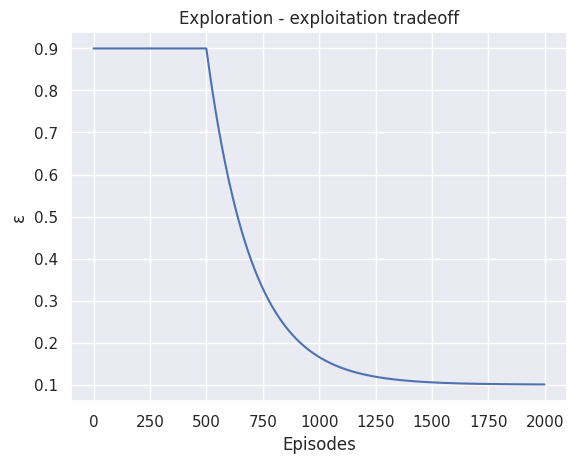

In [8]:
episodes = np.arange(p.total_episodes)
expl = np.zeros_like(episodes, dtype=float)
for idx, ep in enumerate(episodes):
    expl[idx] = explorer.update_epsilon(ep)

fig, ax = plt.subplots()
ax.plot(episodes, expl)
ax.set_title("Exploration - exploitation tradeoff")
ax.set_xlabel("Episodes")
ax.set_ylabel("ε")
plt.show()

In [9]:
def run_env():
    rewards = np.zeros((p.total_episodes, p.n_runs))
    steps = np.zeros((p.total_episodes, p.n_runs))
    episodes = np.arange(p.total_episodes)
    qtables = np.zeros((p.n_runs, p.state_size, p.action_size))
    all_states = []
    all_actions = []

    for run in range(p.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{p.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=p.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            for step in range(p.max_steps):
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Record states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward

                # Our new state is state
                state = new_state

                if done == True:
                    break

            explorer.epsilon = explorer.update_epsilon(episode)

            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [10]:
# rewards, steps, episodes = run_env()

In [11]:
# print(f"Score over time: {sum(rewards) / p.total_episodes}")
# print(f"Final epsilon: {explorer.epsilon}")

### Visualization

In [12]:
# res = pd.DataFrame(
#     data={
#         "Episodes": np.tile(episodes, reps=p.n_runs),
#         "Rewards": rewards.flatten(),
#         "Steps": steps.flatten(),
#     }
# )
# res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# res["map_size"] = np.repeat(f"{p.map_size}x{p.map_size}", res.shape[0])
# res

In [13]:
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
# st["map_size"] = np.repeat(f"{p.map_size}x{p.map_size}", st.shape[0])
# st

In [14]:
def plot_steps_and_rewards(df1, df2):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    # sns.lineplot(data=df1, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0])
    # ax[0].set(ylabel="Cummulated rewards")
    sns.lineplot(data=df1, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0])
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=df2, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    plt.show()

In [15]:
# plot_steps_and_rewards(res, st)

In [16]:
# qtable_val_max = learner.qtable.max(axis=1).reshape(p.map_size, p.map_size)
# qtable_best_action = np.argmax(learner.qtable, axis=1).reshape(p.map_size, p.map_size)
# directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
# qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
# eps = np.finfo(float).eps
# for idx, val in enumerate(qtable_best_action.flatten()):
#     if qtable_val_max.flatten()[idx] > eps:
#         qtable_directions[idx] = directions[val]
# qtable_directions = qtable_directions.reshape(p.map_size, p.map_size)

# # print("Q-table:")
# # print(learner.qtable)
# # Print the action in every place
# print("Best action Q-value:")
# print(qtable_val_max)
# print("Best action learned:")
# print("LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3")
# print(qtable_best_action)
# print(qtable_directions)

In [17]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions


def plot_q_values_map(qtable, env, map_size):
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    font_name = "DejaVu Math TeX Gyre"
    mpl.rcParams["font.family"] = font_name
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    im = ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

In [18]:
# plot_q_values_map(learner.qtable, env, p.map_size)

In [19]:
# # All the episoded is the same
# # taking the maximum of Qtable value every time.
# env.reset(seed=p.seed)
# # img = plt.imshow(env.render()[0])
# for episode in range(5):
#     state = env.reset(seed=p.seed)[0]
#     step = 0
#     done = False
#     print(f"EPISODE {episode}")

#     for step in range(p.max_steps):
#         # Take the action (index) that have the maximum expected future reward given that state
#         action = np.argmax(learner.qtable[state, :])

#         new_state, reward, terminated, truncated, info = env.step(action)

#         done = terminated or truncated
#         if done:
#             break
#         state = new_state

In [20]:
# env.close()

In [21]:
def plot_states_actions_distribution(states, actions):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(2, 1)
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    plt.show()

Map size: 4x4


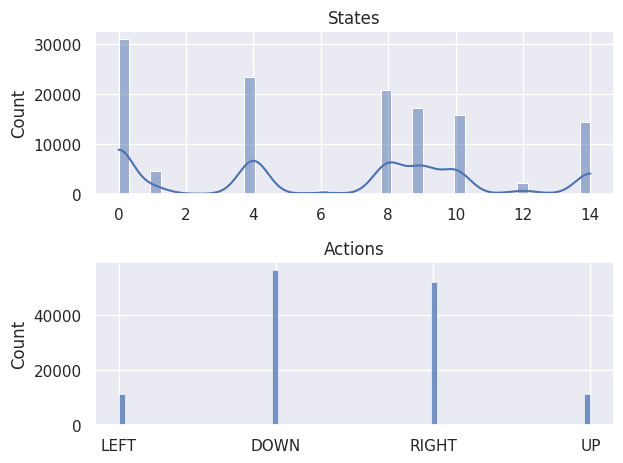

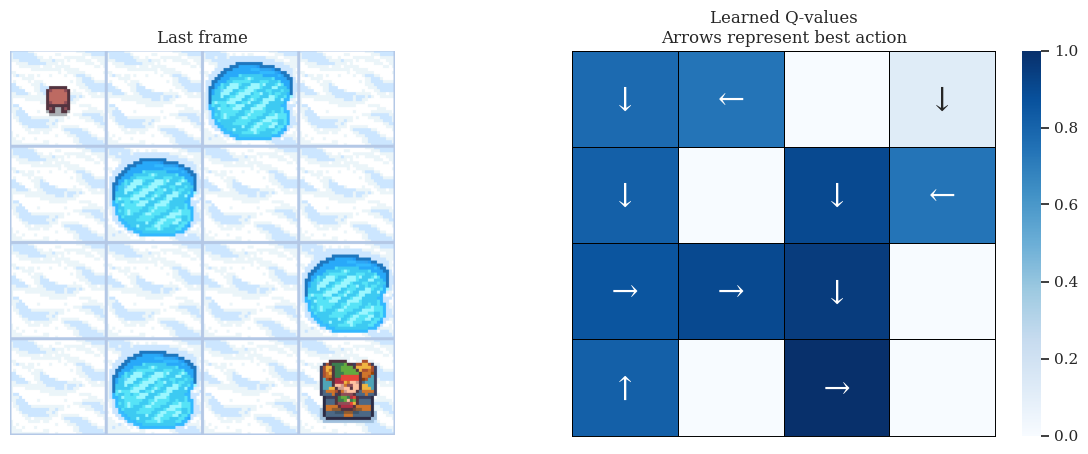

Map size: 8x8


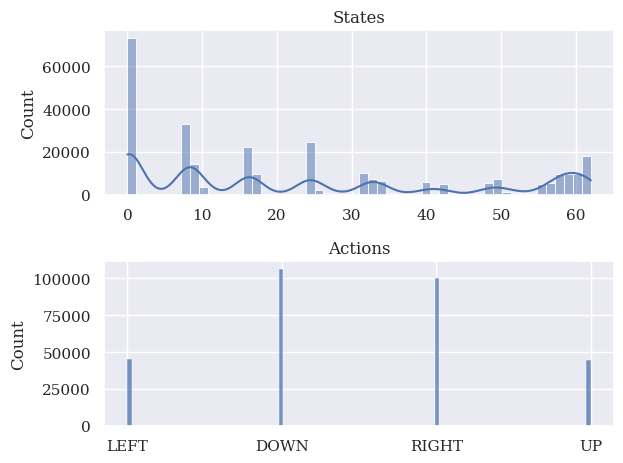

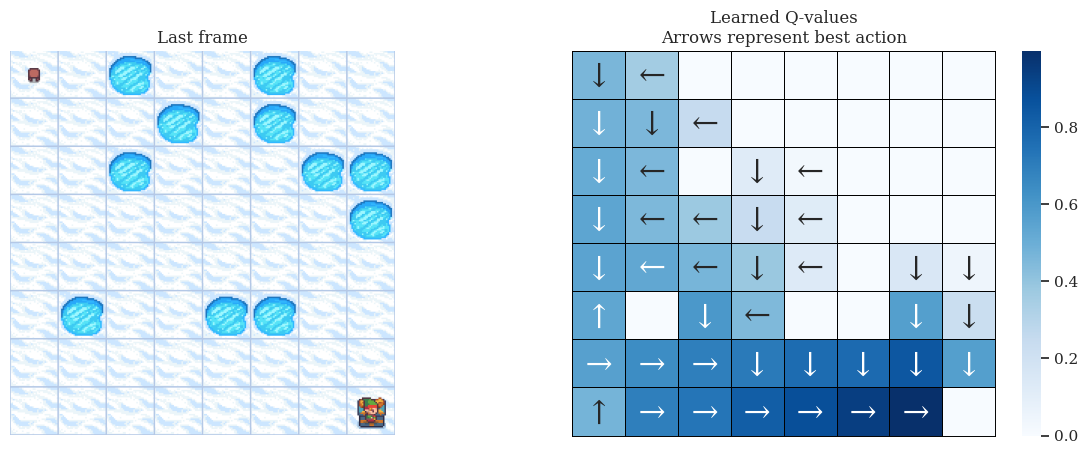

Map size: 12x12


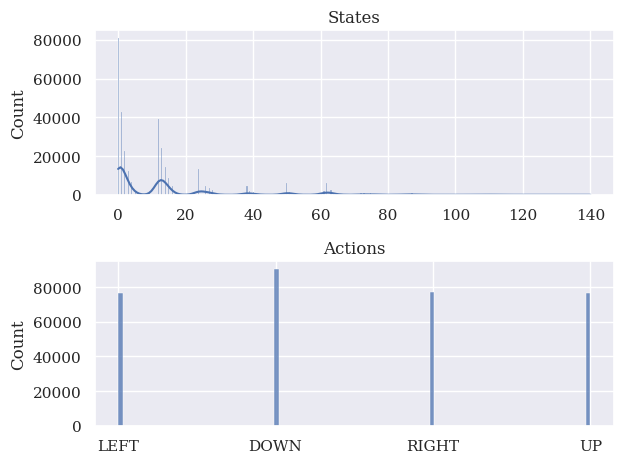

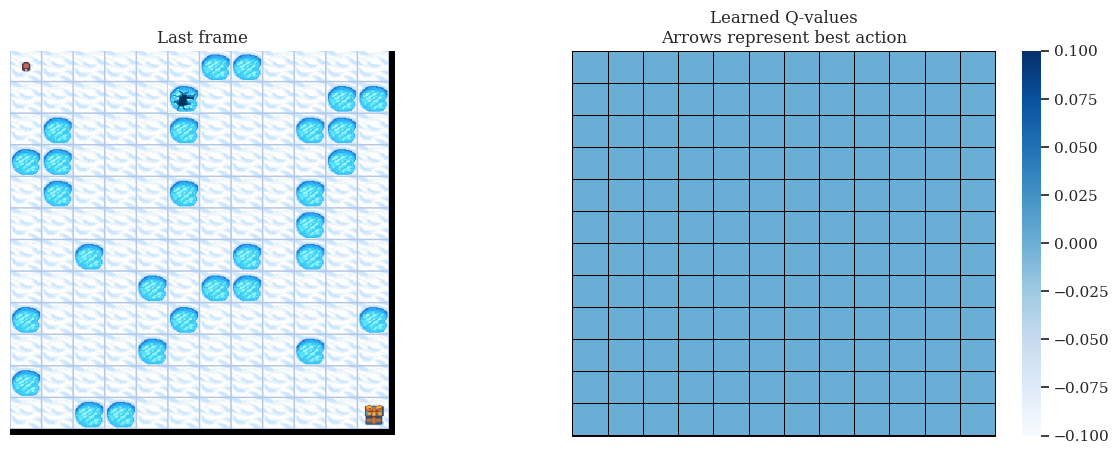

In [22]:
map_sizes = [4, 8, 12]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    # env = gym.make(
    #     "FrozenLake-v1",
    #     is_slippery=p.is_slippery,
    #     render_mode="rgb_array",
    #     desc=generate_random_map(size=map_size, p=p.proba_frozen, seed=p.seed),
    # )
    env = gym.make(
        "LagoGelato",
        is_slippery=p.is_slippery,
        render_mode="rgb_array",
        desc=lago_gelato.generate_random_map(
            size=map_size, p=p.proba_frozen, seed=p.seed
        ),
    )

    p = p._replace(action_size=env.action_space.n)
    p = p._replace(state_size=env.observation_space.n)
    learner = Qlearning(
        learning_rate=p.learning_rate,
        gamma=p.gamma,
        state_size=p.state_size,
        action_size=p.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon_min=p.epsilon_min,
        epsilon_max=p.epsilon_max,
        decay_rate=p.decay_rate,
        epsilon_warmup=p.epsilon_warmup,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=p.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])
    res_all = pd.concat([res_all, res])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    st_all = pd.concat([st_all, st])

    plot_states_actions_distribution(all_states, all_actions)  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

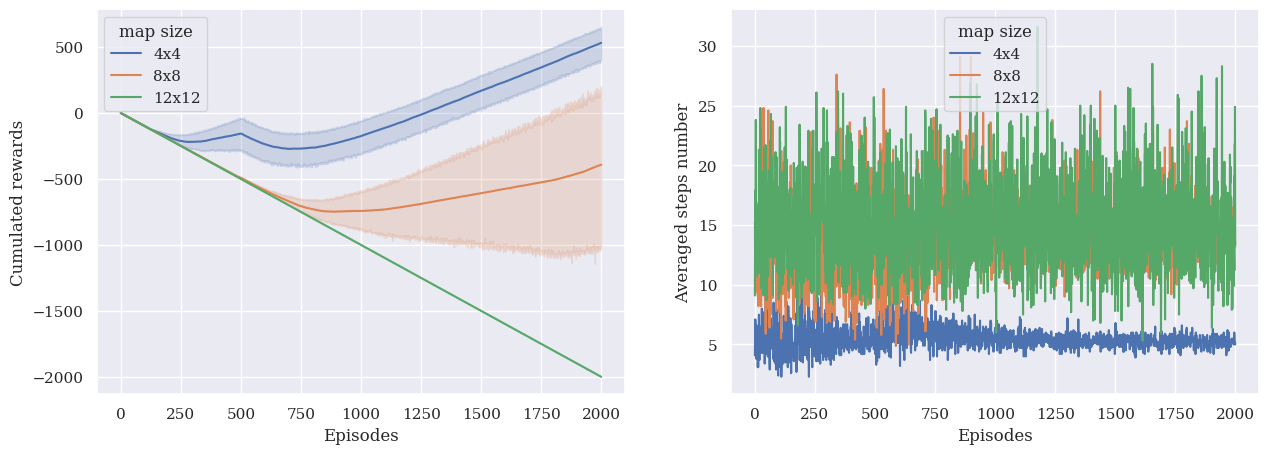

In [23]:
plot_steps_and_rewards(res_all, st_all)

In the end, if agent doesn't get any rewards, rewards don't get propagated in the Q-values, and the agent doesn't learn anything. In my experience on this environment using Epsilon greedy and those hyperparameters and environment settings, maps having more than 11x11 tiles start to be difficult to solve. Maybe using a different exploration algorithm could overcome this. The other parameter having a big impact is the `proba_frozen`, the probability of the tile being frozen. With too many holes, i.e. $p<0.9$, Q-learning is having a hard time not falling into the holes and getting a reward signal.

## References
- Code inspired from [Deep Reinforcement Learning Course](https://simoninithomas.github.io/Deep_reinforcement_learning_Course/) by Thomas Simonini (http://simoninithomas.com/)
- [Dissecting Reinforcement Learning-Part.2](https://mpatacchiola.github.io/blog/2017/01/15/dissecting-reinforcement-learning-2.html)
- [Dadid Silver’s course](https://www.davidsilver.uk/teaching/) in particular lesson 4 and lesson 5
- [Q-learning article on Wikipedia](https://en.wikipedia.org/wiki/Q-learning)
- [Q-Learning: Off-Policy TD Control](http://incompleteideas.net/book/ebook/node65.html) in [Reinforcement Learning: An Introduction, by Richard S. Sutton and Andrew G. Barto](http://incompleteideas.net/book/ebook/)
- [Epsilon-Greedy Q-learning](https://www.baeldung.com/cs/epsilon-greedy-q-learning)